# Проект - Credit Scoring 
### Описание

Первая и самая важная цель банка — заработать деньги. Если банк будет вести слишком жесткую политику, не выдавая кредиты даже тем, кто вернул бы деньги, то он не заработает на процентах. Отказ в кредите хорошему заемщику — ошибка первого рода. Риск, с которым сталкивается кредитная организация — дать кредит неблагонадёжному заёмщику, который впоследствии может допустить дефолт, а банк потеряет деньги — ошибка второго рода.

Чтобы соблюсти баланс, используется кредитный скоринг, который позволяет спрогнозировать вероятность невозврата кредита. Клиентов, обратившихся за кредитом, сортируют по этой предсказанной вероятности (по убыванию), и получается скоркарта — рейтинг клиентов от плохих к хорошим.

Используя данные о клиенте, работник банка может решить, выдавать ли клиенту кредит, и если да, то под какой процент.

При этом используемый в кредитном скоринге алгоритм позволяет предсказывать значения непрерывной зависимой переменной на интервале от до . Банки самостоятельно определяют для себя значения, при которых они принимают решение об отказе в кредите.

Цель проекта - выбрать наиболее эффективную модель оценки качества клиентов банка.

## Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

План:
посмотреть признаки и их баланс добавить новые признаки

## Обзор данных

In [2]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import catboost
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')
seed = 42

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [6]:
train

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


### EDA

In [7]:
train_inf = train.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(train.isnull().sum(), name='null'))\
    .append(pd.Series(train.dtypes, name='dtype'))\
    .transpose()

train_inf

,<lambda>,nunique,null,dtype
client_id,"[25905, 63161, 25887, 16222, 101655, 41415, 28...",73799,0,int64
app_date,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",120,0,object
education,"[SCH, GRD, UGR, PGR, ACD, nan]",5,307,object
sex,"[M, F]",2,0,object
age,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29]",52,0,int64
car,"[Y, N]",2,0,object
car_type,"[Y, N]",2,0,object
decline_app_cnt,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9]",21,0,int64
good_work,"[0, 1]",2,0,int64
score_bki,"[-2.00875292, -1.53227621, -1.40814226, -2.057...",69096,0,float64


In [8]:
test_inf = test.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(train.isnull().sum(), name='null'))\
    .append(pd.Series(train.dtypes, name='dtype'))\
    .transpose()

test_inf

,nunique,<lambda>,null,dtype
client_id,36349,"[74835, 17527, 75683, 26883, 28862, 99881, 266...",0,int64
app_date,120,"[22MAR2014, 24JAN2014, 23MAR2014, 03FEB2014, 0...",0,object
education,5,"[GRD, SCH, UGR, PGR, nan, ACD]",307,object
sex,2,"[M, F]",0,object
age,51,"[29, 39, 50, 56, 38, 55, 30, 41, 34, 28]",0,int64
car,2,"[Y, N]",0,object
car_type,2,"[Y, N]",0,object
decline_app_cnt,19,"[0, 5, 3, 1, 2, 6, 4, 8, 10, 7]",0,int64
good_work,2,"[0, 1]",0,int64
score_bki,34287,"[-2.27188367, -1.50499915, -1.69133904, -2.374...",0,float64


Использован автоматический профайлинг. Чтобы не перегружать блокнот, результат выгружен в отдельный файл (есть в репозитории). 

In [9]:
# import pandas_profiling
# path=''
# pandas_profiling.ProfileReport(train).to_file(path+"prof_traindf.html")

In [20]:
bin_cols = ['sex', 'car', "car_type", 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


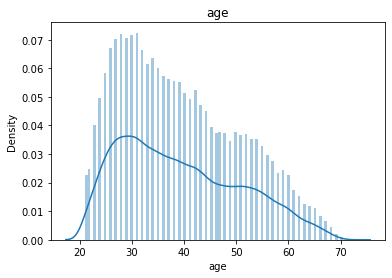

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


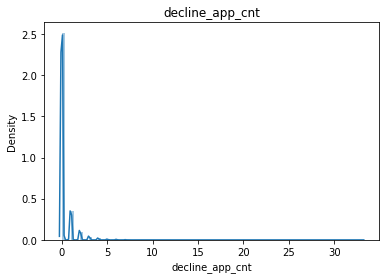

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


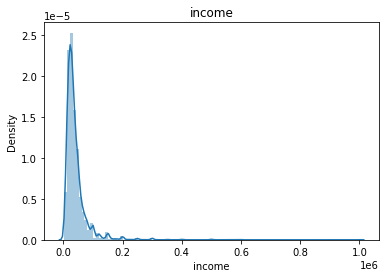

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


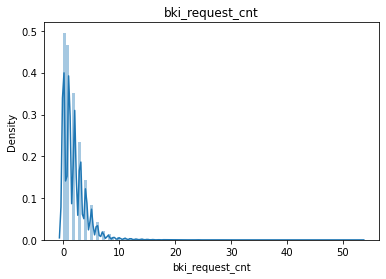

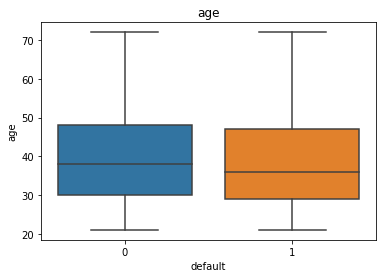

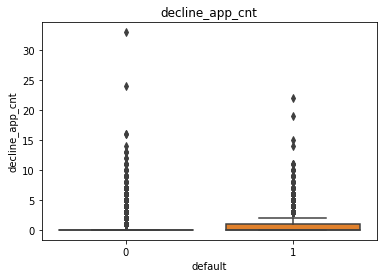

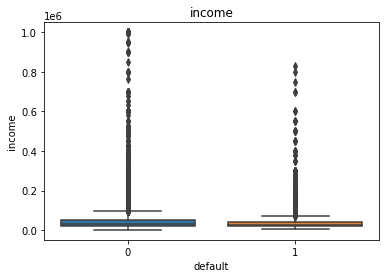

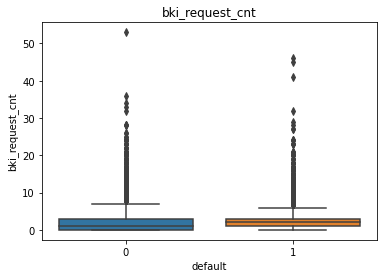

In [12]:
for i in num_cols:
    plt.figure()
    sns.distplot(train[i], bins = 100)
    plt.title(i)
    plt.show()
for i in num_cols:
    plt.figure()
    sns.boxplot(x = train['default'], y = train[i])
    plt.title(i)
    plt.show()

<AxesSubplot:>

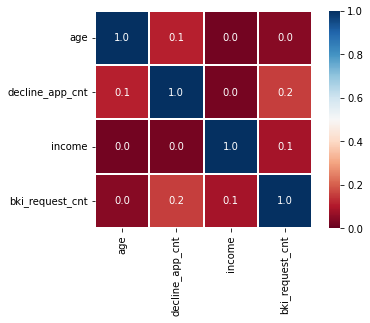

In [15]:
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
              annot=True, 
            fmt=".1f", 
            linewidths=0.1, 
            cmap="RdBu")

<AxesSubplot:>

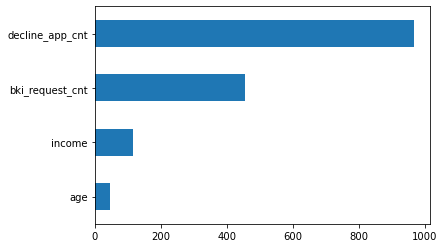

In [16]:
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

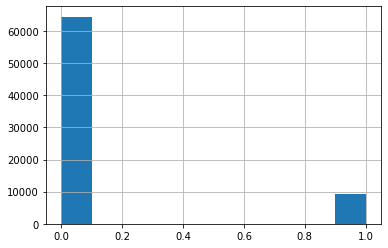

In [32]:
train.default.hist()

1. Имеется датасет из 73799 записей. Дубликатов нет. Пропуски имеются только в колонке образования, будут заменены на моду.
2. Нет сильно скреллированых с таргет-переменной признаков. Наиболее значимые по корреляции признаки это score_bci и decline_app_cnt. Также есть 2 сильно скоррелированных между собой признака - рабочий и домашний адреса, однако удалять один из них пока не буду.
3. Большинство числовых переменных смещены влево, в продобработке можно будет их прологарифмировать.
4. Целевая переменная сильно несбалансирована 1 к 6.5 - это будет учтено в модели.


## BaseLine

Для задачи такого типа лучше всего подходит модель на основе бустинга. Я выбираю CatBoost, как одну из лучших библиотек.
Для начала попробую использовать необработанные данные и параметры модели по умолчанию и посмотреть результат, а потом попытаться улучшить его с помощью различных способов предобработки данных и оптимизации гиперпараметров.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.05552
0:	learn: 0.6476048	total: 292ms	remaining: 4m 51s
1:	learn: 0.6094799	total: 445ms	remaining: 3m 41s
2:	learn: 0.5769923	total: 629ms	remaining: 3m 29s
3:	learn: 0.5500787	total: 766ms	remaining: 3m 10s
4:	learn: 0.5254810	total: 877ms	remaining: 2m 54s
5:	learn: 0.5058995	total: 1.06s	remaining: 2m 56s
6:	learn: 0.4863469	total: 1.2s	remaining: 2m 49s
7:	learn: 0.4699278	total: 1.36s	remaining: 2m 49s
8:	learn: 0.4574607	total: 1.43s	remaining: 2m 37s
9:	learn: 0.4439149	total: 1.59s	remaining: 2m 37s
10:	learn: 0.4331394	total: 1.73s	remaining: 2m 35s
11:	learn: 0.4247343	total: 1.8s	remaining: 2m 27s
12:	learn: 0.4154258	total: 1.97s	remaining: 2m 29s
13:	learn: 0.4078203	total: 2.08s	remaining: 2m 26s
14:	learn: 0.4013176	total: 2.2s	remaining: 2m 24s
15:	learn: 0.3952775	total: 2.3s	remaining: 2m 21s
16:	learn: 0.3902371	total: 2.42s	remaining: 2m 19s
17:	learn: 0.3855701	total: 2.55s	remaining: 2m 19s
18:	learn: 0.3817360	total: 2.7s	remaining: 2m 19

159:	learn: 0.3324459	total: 17.5s	remaining: 1m 31s
160:	learn: 0.3323997	total: 17.6s	remaining: 1m 31s
161:	learn: 0.3323043	total: 17.7s	remaining: 1m 31s
162:	learn: 0.3322476	total: 17.8s	remaining: 1m 31s
163:	learn: 0.3321748	total: 17.9s	remaining: 1m 31s
164:	learn: 0.3321231	total: 18s	remaining: 1m 31s
165:	learn: 0.3320486	total: 18.1s	remaining: 1m 31s
166:	learn: 0.3319831	total: 18.2s	remaining: 1m 30s
167:	learn: 0.3319292	total: 18.3s	remaining: 1m 30s
168:	learn: 0.3318810	total: 18.4s	remaining: 1m 30s
169:	learn: 0.3318080	total: 18.5s	remaining: 1m 30s
170:	learn: 0.3317198	total: 18.6s	remaining: 1m 30s
171:	learn: 0.3316613	total: 18.7s	remaining: 1m 30s
172:	learn: 0.3316089	total: 18.8s	remaining: 1m 29s
173:	learn: 0.3315495	total: 18.9s	remaining: 1m 29s
174:	learn: 0.3314936	total: 19s	remaining: 1m 29s
175:	learn: 0.3314330	total: 19.1s	remaining: 1m 29s
176:	learn: 0.3313805	total: 19.2s	remaining: 1m 29s
177:	learn: 0.3312975	total: 19.3s	remaining: 1m 2

315:	learn: 0.3239390	total: 34.7s	remaining: 1m 15s
316:	learn: 0.3238374	total: 34.8s	remaining: 1m 14s
317:	learn: 0.3238096	total: 34.9s	remaining: 1m 14s
318:	learn: 0.3237790	total: 35s	remaining: 1m 14s
319:	learn: 0.3237276	total: 35.1s	remaining: 1m 14s
320:	learn: 0.3236976	total: 35.2s	remaining: 1m 14s
321:	learn: 0.3236622	total: 35.4s	remaining: 1m 14s
322:	learn: 0.3236016	total: 35.5s	remaining: 1m 14s
323:	learn: 0.3235564	total: 35.6s	remaining: 1m 14s
324:	learn: 0.3235235	total: 35.7s	remaining: 1m 14s
325:	learn: 0.3234754	total: 35.8s	remaining: 1m 13s
326:	learn: 0.3234441	total: 35.9s	remaining: 1m 13s
327:	learn: 0.3234081	total: 36s	remaining: 1m 13s
328:	learn: 0.3233342	total: 36.2s	remaining: 1m 13s
329:	learn: 0.3233152	total: 36.3s	remaining: 1m 13s
330:	learn: 0.3232598	total: 36.4s	remaining: 1m 13s
331:	learn: 0.3232185	total: 36.6s	remaining: 1m 13s
332:	learn: 0.3231788	total: 36.7s	remaining: 1m 13s
333:	learn: 0.3231475	total: 36.8s	remaining: 1m 1

474:	learn: 0.3170603	total: 52.7s	remaining: 58.3s
475:	learn: 0.3170112	total: 52.8s	remaining: 58.1s
476:	learn: 0.3169748	total: 52.9s	remaining: 58.1s
477:	learn: 0.3169196	total: 53s	remaining: 57.9s
478:	learn: 0.3168664	total: 53.1s	remaining: 57.8s
479:	learn: 0.3168392	total: 53.3s	remaining: 57.7s
480:	learn: 0.3167984	total: 53.3s	remaining: 57.6s
481:	learn: 0.3167790	total: 53.5s	remaining: 57.5s
482:	learn: 0.3167619	total: 53.6s	remaining: 57.4s
483:	learn: 0.3167356	total: 53.7s	remaining: 57.2s
484:	learn: 0.3166890	total: 53.8s	remaining: 57.1s
485:	learn: 0.3166556	total: 53.9s	remaining: 57s
486:	learn: 0.3166221	total: 54s	remaining: 56.9s
487:	learn: 0.3166006	total: 54.1s	remaining: 56.8s
488:	learn: 0.3165857	total: 54.2s	remaining: 56.6s
489:	learn: 0.3165586	total: 54.3s	remaining: 56.5s
490:	learn: 0.3165163	total: 54.4s	remaining: 56.4s
491:	learn: 0.3164660	total: 54.5s	remaining: 56.3s
492:	learn: 0.3164290	total: 54.6s	remaining: 56.2s
493:	learn: 0.3163

635:	learn: 0.3108989	total: 1m 10s	remaining: 40.2s
636:	learn: 0.3108900	total: 1m 10s	remaining: 40.1s
637:	learn: 0.3108722	total: 1m 10s	remaining: 40s
638:	learn: 0.3108523	total: 1m 10s	remaining: 39.9s
639:	learn: 0.3107771	total: 1m 10s	remaining: 39.8s
640:	learn: 0.3107480	total: 1m 10s	remaining: 39.7s
641:	learn: 0.3107214	total: 1m 10s	remaining: 39.6s
642:	learn: 0.3106659	total: 1m 11s	remaining: 39.5s
643:	learn: 0.3106260	total: 1m 11s	remaining: 39.4s
644:	learn: 0.3105820	total: 1m 11s	remaining: 39.3s
645:	learn: 0.3105284	total: 1m 11s	remaining: 39.1s
646:	learn: 0.3104930	total: 1m 11s	remaining: 39s
647:	learn: 0.3104407	total: 1m 11s	remaining: 38.9s
648:	learn: 0.3103971	total: 1m 11s	remaining: 38.8s
649:	learn: 0.3103643	total: 1m 11s	remaining: 38.7s
650:	learn: 0.3103028	total: 1m 11s	remaining: 38.6s
651:	learn: 0.3102625	total: 1m 12s	remaining: 38.5s
652:	learn: 0.3102217	total: 1m 12s	remaining: 38.3s
653:	learn: 0.3101523	total: 1m 12s	remaining: 38.

792:	learn: 0.3050218	total: 1m 26s	remaining: 22.6s
793:	learn: 0.3050017	total: 1m 26s	remaining: 22.5s
794:	learn: 0.3049676	total: 1m 26s	remaining: 22.4s
795:	learn: 0.3049574	total: 1m 26s	remaining: 22.3s
796:	learn: 0.3049229	total: 1m 27s	remaining: 22.2s
797:	learn: 0.3048616	total: 1m 27s	remaining: 22.1s
798:	learn: 0.3048218	total: 1m 27s	remaining: 21.9s
799:	learn: 0.3047289	total: 1m 27s	remaining: 21.8s
800:	learn: 0.3047036	total: 1m 27s	remaining: 21.7s
801:	learn: 0.3046533	total: 1m 27s	remaining: 21.6s
802:	learn: 0.3046249	total: 1m 27s	remaining: 21.5s
803:	learn: 0.3045692	total: 1m 27s	remaining: 21.4s
804:	learn: 0.3045373	total: 1m 27s	remaining: 21.3s
805:	learn: 0.3045043	total: 1m 27s	remaining: 21.2s
806:	learn: 0.3044581	total: 1m 28s	remaining: 21.1s
807:	learn: 0.3044141	total: 1m 28s	remaining: 20.9s
808:	learn: 0.3043627	total: 1m 28s	remaining: 20.8s
809:	learn: 0.3043075	total: 1m 28s	remaining: 20.7s
810:	learn: 0.3042611	total: 1m 28s	remaining:

949:	learn: 0.2995333	total: 1m 44s	remaining: 5.47s
950:	learn: 0.2995013	total: 1m 44s	remaining: 5.37s
951:	learn: 0.2994687	total: 1m 44s	remaining: 5.26s
952:	learn: 0.2994429	total: 1m 44s	remaining: 5.15s
953:	learn: 0.2994378	total: 1m 44s	remaining: 5.04s
954:	learn: 0.2993785	total: 1m 44s	remaining: 4.93s
955:	learn: 0.2993516	total: 1m 44s	remaining: 4.82s
956:	learn: 0.2993371	total: 1m 44s	remaining: 4.71s
957:	learn: 0.2993140	total: 1m 44s	remaining: 4.6s
958:	learn: 0.2992976	total: 1m 44s	remaining: 4.49s
959:	learn: 0.2992658	total: 1m 45s	remaining: 4.38s
960:	learn: 0.2992087	total: 1m 45s	remaining: 4.27s
961:	learn: 0.2991716	total: 1m 45s	remaining: 4.16s
962:	learn: 0.2991636	total: 1m 45s	remaining: 4.05s
963:	learn: 0.2991441	total: 1m 45s	remaining: 3.94s
964:	learn: 0.2991075	total: 1m 45s	remaining: 3.83s
965:	learn: 0.2990515	total: 1m 45s	remaining: 3.72s
966:	learn: 0.2990405	total: 1m 45s	remaining: 3.61s
967:	learn: 0.2990134	total: 1m 45s	remaining: 

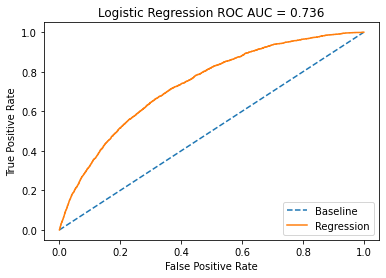

In [24]:
X, y = train.drop(columns= ['default']).fillna('SCH'), train.default 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=seed )


m = CatBoostClassifier()
m.fit(X_train, y_train,cat_features=list(train.select_dtypes(include=['object']).columns) , plot=True)
probs = m.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

0.736!

Прекрасный результат для первого раза учитывая что не было проделанно почти никакой предобработки.

In [26]:
# Пробуем его на Kaggle
m = CatBoostClassifier()
# print(X, y,cat)
m.fit(X, y,cat_features=list(train.select_dtypes(include=['object']).columns))
probs = m.predict_proba(test)
test['default'] = probs[:,1]
test[['client_id', 'default']]
test[['client_id', 'default']].to_csv('subm_1.csv', index=False)

Learning rate set to 0.064653
0:	learn: 0.6418901	total: 131ms	remaining: 2m 11s
1:	learn: 0.5990630	total: 265ms	remaining: 2m 12s
2:	learn: 0.5620207	total: 392ms	remaining: 2m 10s
3:	learn: 0.5313220	total: 526ms	remaining: 2m 11s
4:	learn: 0.5052901	total: 668ms	remaining: 2m 12s
5:	learn: 0.4835509	total: 806ms	remaining: 2m 13s
6:	learn: 0.4644046	total: 933ms	remaining: 2m 12s
7:	learn: 0.4483558	total: 1.07s	remaining: 2m 12s
8:	learn: 0.4346443	total: 1.19s	remaining: 2m 11s
9:	learn: 0.4232835	total: 1.33s	remaining: 2m 12s
10:	learn: 0.4137958	total: 1.47s	remaining: 2m 12s
11:	learn: 0.4052128	total: 1.61s	remaining: 2m 12s
12:	learn: 0.3971811	total: 1.74s	remaining: 2m 11s
13:	learn: 0.3904684	total: 1.87s	remaining: 2m 12s
14:	learn: 0.3848891	total: 2s	remaining: 2m 11s
15:	learn: 0.3797696	total: 2.15s	remaining: 2m 12s
16:	learn: 0.3755021	total: 2.27s	remaining: 2m 11s
17:	learn: 0.3716598	total: 2.42s	remaining: 2m 11s
18:	learn: 0.3680111	total: 2.56s	remaining: 2m

160:	learn: 0.3319874	total: 22.2s	remaining: 1m 55s
161:	learn: 0.3319242	total: 22.4s	remaining: 1m 55s
162:	learn: 0.3319226	total: 22.4s	remaining: 1m 55s
163:	learn: 0.3318770	total: 22.6s	remaining: 1m 55s
164:	learn: 0.3318509	total: 22.7s	remaining: 1m 54s
165:	learn: 0.3317919	total: 22.8s	remaining: 1m 54s
166:	learn: 0.3317292	total: 22.9s	remaining: 1m 54s
167:	learn: 0.3317010	total: 23.1s	remaining: 1m 54s
168:	learn: 0.3316508	total: 23.2s	remaining: 1m 54s
169:	learn: 0.3315840	total: 23.3s	remaining: 1m 53s
170:	learn: 0.3315358	total: 23.5s	remaining: 1m 53s
171:	learn: 0.3314931	total: 23.6s	remaining: 1m 53s
172:	learn: 0.3314312	total: 23.8s	remaining: 1m 53s
173:	learn: 0.3313861	total: 23.9s	remaining: 1m 53s
174:	learn: 0.3313585	total: 24.1s	remaining: 1m 53s
175:	learn: 0.3312908	total: 24.2s	remaining: 1m 53s
176:	learn: 0.3312329	total: 24.3s	remaining: 1m 53s
177:	learn: 0.3311744	total: 24.5s	remaining: 1m 53s
178:	learn: 0.3311008	total: 24.6s	remaining: 

317:	learn: 0.3254727	total: 44.4s	remaining: 1m 35s
318:	learn: 0.3254272	total: 44.5s	remaining: 1m 35s
319:	learn: 0.3253977	total: 44.7s	remaining: 1m 34s
320:	learn: 0.3253445	total: 44.8s	remaining: 1m 34s
321:	learn: 0.3253202	total: 44.9s	remaining: 1m 34s
322:	learn: 0.3252679	total: 45s	remaining: 1m 34s
323:	learn: 0.3252250	total: 45.2s	remaining: 1m 34s
324:	learn: 0.3252012	total: 45.3s	remaining: 1m 34s
325:	learn: 0.3251406	total: 45.4s	remaining: 1m 33s
326:	learn: 0.3251031	total: 45.6s	remaining: 1m 33s
327:	learn: 0.3250619	total: 45.7s	remaining: 1m 33s
328:	learn: 0.3250236	total: 45.8s	remaining: 1m 33s
329:	learn: 0.3249738	total: 46s	remaining: 1m 33s
330:	learn: 0.3249449	total: 46.1s	remaining: 1m 33s
331:	learn: 0.3248998	total: 46.2s	remaining: 1m 33s
332:	learn: 0.3248709	total: 46.4s	remaining: 1m 32s
333:	learn: 0.3248257	total: 46.5s	remaining: 1m 32s
334:	learn: 0.3247913	total: 46.6s	remaining: 1m 32s
335:	learn: 0.3247625	total: 46.7s	remaining: 1m 3

474:	learn: 0.3195639	total: 1m 4s	remaining: 1m 11s
475:	learn: 0.3195469	total: 1m 4s	remaining: 1m 11s
476:	learn: 0.3195100	total: 1m 4s	remaining: 1m 11s
477:	learn: 0.3194665	total: 1m 4s	remaining: 1m 10s
478:	learn: 0.3194278	total: 1m 5s	remaining: 1m 10s
479:	learn: 0.3194261	total: 1m 5s	remaining: 1m 10s
480:	learn: 0.3193975	total: 1m 5s	remaining: 1m 10s
481:	learn: 0.3193627	total: 1m 5s	remaining: 1m 10s
482:	learn: 0.3193554	total: 1m 5s	remaining: 1m 10s
483:	learn: 0.3193401	total: 1m 5s	remaining: 1m 10s
484:	learn: 0.3193182	total: 1m 5s	remaining: 1m 9s
485:	learn: 0.3192947	total: 1m 6s	remaining: 1m 9s
486:	learn: 0.3192619	total: 1m 6s	remaining: 1m 9s
487:	learn: 0.3192419	total: 1m 6s	remaining: 1m 9s
488:	learn: 0.3192152	total: 1m 6s	remaining: 1m 9s
489:	learn: 0.3191663	total: 1m 6s	remaining: 1m 9s
490:	learn: 0.3191344	total: 1m 6s	remaining: 1m 9s
491:	learn: 0.3190996	total: 1m 6s	remaining: 1m 8s
492:	learn: 0.3190446	total: 1m 6s	remaining: 1m 8s
49

630:	learn: 0.3145075	total: 1m 24s	remaining: 49.4s
631:	learn: 0.3144702	total: 1m 24s	remaining: 49.3s
632:	learn: 0.3144233	total: 1m 24s	remaining: 49.2s
633:	learn: 0.3144068	total: 1m 24s	remaining: 49s
634:	learn: 0.3143874	total: 1m 25s	remaining: 48.9s
635:	learn: 0.3143705	total: 1m 25s	remaining: 48.7s
636:	learn: 0.3143388	total: 1m 25s	remaining: 48.6s
637:	learn: 0.3143102	total: 1m 25s	remaining: 48.5s
638:	learn: 0.3142839	total: 1m 25s	remaining: 48.3s
639:	learn: 0.3142625	total: 1m 25s	remaining: 48.2s
640:	learn: 0.3142213	total: 1m 25s	remaining: 48.1s
641:	learn: 0.3141932	total: 1m 25s	remaining: 47.9s
642:	learn: 0.3141707	total: 1m 26s	remaining: 47.8s
643:	learn: 0.3141467	total: 1m 26s	remaining: 47.7s
644:	learn: 0.3141300	total: 1m 26s	remaining: 47.5s
645:	learn: 0.3141079	total: 1m 26s	remaining: 47.4s
646:	learn: 0.3140977	total: 1m 26s	remaining: 47.3s
647:	learn: 0.3140632	total: 1m 26s	remaining: 47.2s
648:	learn: 0.3140432	total: 1m 27s	remaining: 4

787:	learn: 0.3098723	total: 1m 48s	remaining: 29.2s
788:	learn: 0.3098482	total: 1m 48s	remaining: 29.1s
789:	learn: 0.3098091	total: 1m 48s	remaining: 28.9s
790:	learn: 0.3097875	total: 1m 48s	remaining: 28.8s
791:	learn: 0.3097613	total: 1m 49s	remaining: 28.7s
792:	learn: 0.3097310	total: 1m 49s	remaining: 28.6s
793:	learn: 0.3097136	total: 1m 49s	remaining: 28.4s
794:	learn: 0.3096859	total: 1m 49s	remaining: 28.3s
795:	learn: 0.3096563	total: 1m 49s	remaining: 28.2s
796:	learn: 0.3096313	total: 1m 50s	remaining: 28s
797:	learn: 0.3096001	total: 1m 50s	remaining: 27.9s
798:	learn: 0.3095996	total: 1m 50s	remaining: 27.8s
799:	learn: 0.3095916	total: 1m 50s	remaining: 27.6s
800:	learn: 0.3095679	total: 1m 50s	remaining: 27.5s
801:	learn: 0.3095436	total: 1m 50s	remaining: 27.4s
802:	learn: 0.3095137	total: 1m 50s	remaining: 27.2s
803:	learn: 0.3094981	total: 1m 51s	remaining: 27.1s
804:	learn: 0.3094886	total: 1m 51s	remaining: 26.9s
805:	learn: 0.3094671	total: 1m 51s	remaining: 2

945:	learn: 0.3053116	total: 2m 10s	remaining: 7.48s
946:	learn: 0.3052976	total: 2m 11s	remaining: 7.34s
947:	learn: 0.3052706	total: 2m 11s	remaining: 7.2s
948:	learn: 0.3052641	total: 2m 11s	remaining: 7.06s
949:	learn: 0.3052502	total: 2m 11s	remaining: 6.92s
950:	learn: 0.3052051	total: 2m 11s	remaining: 6.78s
951:	learn: 0.3051868	total: 2m 11s	remaining: 6.64s
952:	learn: 0.3051538	total: 2m 11s	remaining: 6.5s
953:	learn: 0.3051071	total: 2m 11s	remaining: 6.36s
954:	learn: 0.3051036	total: 2m 12s	remaining: 6.22s
955:	learn: 0.3050999	total: 2m 12s	remaining: 6.09s
956:	learn: 0.3050823	total: 2m 12s	remaining: 5.95s
957:	learn: 0.3050509	total: 2m 12s	remaining: 5.81s
958:	learn: 0.3050146	total: 2m 12s	remaining: 5.67s
959:	learn: 0.3049904	total: 2m 12s	remaining: 5.53s
960:	learn: 0.3049667	total: 2m 12s	remaining: 5.39s
961:	learn: 0.3049328	total: 2m 13s	remaining: 5.26s
962:	learn: 0.3048946	total: 2m 13s	remaining: 5.12s
963:	learn: 0.3048745	total: 2m 13s	remaining: 4

CatBoostError: Invalid type for cat_feature[non-default value idx=189,feature_idx=2]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

На тестовом датасете результат оказался еще выше - 0.74103, очень неплохо.


## Предобработка

In [30]:
num_cols = ['age', 'num_week', 'dayofweek', 'decline_app_cnt', 'income', 'bki_request_cnt','region_rating']
# scaler = None

def prepros(df):
#добавляем новую колонку дат в формате datatime
#     bin_cols = ['sex', 'car', "car_type", 'good_work', 'foreign_passport']
#     cat_cols = ['education', 'home_address', 'work_address']
    # cat = df[df.dtype == 'object'].index.tolist() + ['region_rating']
#     global scaler
    
    df['education'].fillna('SCH', inplace=True)
    df['education_num']  = df.education.map({'SCH':1,
                                    'UGR':2,
                                    'GRD':3,
                                    'PGR':4,
                                    'ACD':5})
    df['datetime'] = pd.to_datetime(df['app_date'])
    df['num_week'] = df['datetime'].apply(lambda x: x.week)
    df['dayofweek']  = df['datetime'].apply(lambda x: x.dayofweek)
    df['day'] = df['datetime'].apply(lambda x: x.day)
#     df['month']= df['datetime'].apply(lambda x: x.month)
    df = df.drop(columns = ['datetime'])
#     df['income'] = np.log(df['income'])
#     df['bki_request_cnt'] = np.clip(df['bki_request_cnt'],a_min = 0, a_max=16)
#     if scaler is None:
#         scaler = StandardScaler().fit(df[num_cols].values)
#     df[num_cols] = scaler.transform(df[num_cols].values)
# # 'bki_request_cnt'*,'region_rating'** 'decline_app_cnt'** 'decline_app_cnt'*'bki_request_cnt'
#     df['bki_request_cnt*region_rating'] = df['bki_request_cnt']*df['region_rating']
#     df['region_rating**'] = df['region_rating']*df['region_rating']
#     df['decline_app_cnt**'] = df['decline_app_cnt']*df['decline_app_cnt']
#     df['bki_request_cnt*decline_app_cnt'] = df['bki_request_cnt']*df['decline_app_cnt']
#     mean_income_rat = df.groupby('region_rating')['income'].mean().to_dict()
#     df['mean_income_region'] = df['region_rating'].map(mean_income_rat)

#     df['bki_age_reg'] = (df['score_bki']/df['age'])*df['region_rating']

#     for i,col in enumerate(['decline_app_cnt', 'income']):
#         df[col] = np.log(df[col] + 1)

#     mean_income = df.groupby('age')['income'].mean().to_dict()
#     df['mean_income_age'] = df['age'].map(mean_income)
# #     poly = PolynomialFeatures(2)
# #     p = poly.fit_transform(df[num_cols])
#     # p = pd.DataFrame(p, columns = )
# #     df[['c_' + str(i) for i in range(p.shape[1])]]=p
    return df

In [28]:
cat = list(train.select_dtypes(include=['object']).columns) 

## Обучение модели

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6927378	best: 0.6927378 (0)	total: 126ms	remaining: 2m 6s
1:	test: 0.7035792	best: 0.7035792 (1)	total: 244ms	remaining: 2m 2s
2:	test: 0.7040214	best: 0.7040214 (2)	total: 351ms	remaining: 1m 56s
3:	test: 0.7044252	best: 0.7044252 (3)	total: 476ms	remaining: 1m 58s
4:	test: 0.7068393	best: 0.7068393 (4)	total: 643ms	remaining: 2m 7s
5:	test: 0.7060517	best: 0.7068393 (4)	total: 780ms	remaining: 2m 9s
6:	test: 0.7068999	best: 0.7068999 (6)	total: 939ms	remaining: 2m 13s
7:	test: 0.7078692	best: 0.7078692 (7)	total: 1.08s	remaining: 2m 14s
8:	test: 0.7084679	best: 0.7084679 (8)	total: 1.24s	remaining: 2m 16s
9:	test: 0.7096262	best: 0.7096262 (9)	total: 1.4s	remaining: 2m 19s
10:	test: 0.7103391	best: 0.7103391 (10)	total: 1.55s	remaining: 2m 19s
11:	test: 0.7108624	best: 0.7108624 (11)	total: 1.67s	remaining: 2m 17s
12:	test: 0.7134980	best: 0.7134980 (12)	total: 1.81s	remaining: 2m 17s
13:	test: 0.7140315	best: 0.7140315 (13)	total: 1.94s	remaining: 2m 16s
14:	test: 0.71438

115:	test: 0.7381679	best: 0.7381679 (115)	total: 14.5s	remaining: 1m 50s
116:	test: 0.7382574	best: 0.7382574 (116)	total: 14.6s	remaining: 1m 50s
117:	test: 0.7383118	best: 0.7383118 (117)	total: 14.7s	remaining: 1m 49s
118:	test: 0.7383514	best: 0.7383514 (118)	total: 14.8s	remaining: 1m 49s
119:	test: 0.7383775	best: 0.7383775 (119)	total: 14.9s	remaining: 1m 49s
120:	test: 0.7384068	best: 0.7384068 (120)	total: 15s	remaining: 1m 49s
121:	test: 0.7385112	best: 0.7385112 (121)	total: 15.1s	remaining: 1m 48s
122:	test: 0.7386688	best: 0.7386688 (122)	total: 15.2s	remaining: 1m 48s
123:	test: 0.7387356	best: 0.7387356 (123)	total: 15.4s	remaining: 1m 48s
124:	test: 0.7387760	best: 0.7387760 (124)	total: 15.5s	remaining: 1m 48s
125:	test: 0.7387757	best: 0.7387760 (124)	total: 15.6s	remaining: 1m 48s
126:	test: 0.7388264	best: 0.7388264 (126)	total: 15.7s	remaining: 1m 48s
127:	test: 0.7389392	best: 0.7389392 (127)	total: 15.9s	remaining: 1m 48s
128:	test: 0.7389798	best: 0.7389798 (12

229:	test: 0.7414686	best: 0.7414686 (229)	total: 28.1s	remaining: 1m 33s
230:	test: 0.7415037	best: 0.7415037 (230)	total: 28.2s	remaining: 1m 33s
231:	test: 0.7415238	best: 0.7415238 (231)	total: 28.3s	remaining: 1m 33s
232:	test: 0.7415411	best: 0.7415411 (232)	total: 28.4s	remaining: 1m 33s
233:	test: 0.7415604	best: 0.7415604 (233)	total: 28.6s	remaining: 1m 33s
234:	test: 0.7415943	best: 0.7415943 (234)	total: 28.7s	remaining: 1m 33s
235:	test: 0.7416173	best: 0.7416173 (235)	total: 28.8s	remaining: 1m 33s
236:	test: 0.7416083	best: 0.7416173 (235)	total: 28.9s	remaining: 1m 33s
237:	test: 0.7416023	best: 0.7416173 (235)	total: 29s	remaining: 1m 32s
238:	test: 0.7416029	best: 0.7416173 (235)	total: 29.2s	remaining: 1m 32s
239:	test: 0.7415892	best: 0.7416173 (235)	total: 29.3s	remaining: 1m 32s
240:	test: 0.7415934	best: 0.7416173 (235)	total: 29.4s	remaining: 1m 32s
241:	test: 0.7415645	best: 0.7416173 (235)	total: 29.5s	remaining: 1m 32s
242:	test: 0.7415919	best: 0.7416173 (23

341:	test: 0.7424728	best: 0.7424945 (340)	total: 41.4s	remaining: 1m 19s
342:	test: 0.7425226	best: 0.7425226 (342)	total: 41.6s	remaining: 1m 19s
343:	test: 0.7425317	best: 0.7425317 (343)	total: 41.6s	remaining: 1m 19s
344:	test: 0.7425483	best: 0.7425483 (344)	total: 41.8s	remaining: 1m 19s
345:	test: 0.7425399	best: 0.7425483 (344)	total: 41.9s	remaining: 1m 19s
346:	test: 0.7425275	best: 0.7425483 (344)	total: 42.1s	remaining: 1m 19s
347:	test: 0.7425249	best: 0.7425483 (344)	total: 42.2s	remaining: 1m 19s
348:	test: 0.7425073	best: 0.7425483 (344)	total: 42.3s	remaining: 1m 18s
349:	test: 0.7425035	best: 0.7425483 (344)	total: 42.4s	remaining: 1m 18s
350:	test: 0.7425278	best: 0.7425483 (344)	total: 42.5s	remaining: 1m 18s
351:	test: 0.7425165	best: 0.7425483 (344)	total: 42.7s	remaining: 1m 18s
352:	test: 0.7425297	best: 0.7425483 (344)	total: 42.8s	remaining: 1m 18s
353:	test: 0.7425064	best: 0.7425483 (344)	total: 42.9s	remaining: 1m 18s
354:	test: 0.7425080	best: 0.7425483 (

453:	test: 0.7425410	best: 0.7426668 (402)	total: 55.2s	remaining: 1m 6s
454:	test: 0.7425711	best: 0.7426668 (402)	total: 55.3s	remaining: 1m 6s
455:	test: 0.7426022	best: 0.7426668 (402)	total: 55.4s	remaining: 1m 6s
456:	test: 0.7425798	best: 0.7426668 (402)	total: 55.5s	remaining: 1m 5s
457:	test: 0.7425986	best: 0.7426668 (402)	total: 55.6s	remaining: 1m 5s
458:	test: 0.7426078	best: 0.7426668 (402)	total: 55.7s	remaining: 1m 5s
459:	test: 0.7426091	best: 0.7426668 (402)	total: 55.8s	remaining: 1m 5s
460:	test: 0.7425743	best: 0.7426668 (402)	total: 56s	remaining: 1m 5s
461:	test: 0.7425456	best: 0.7426668 (402)	total: 56.1s	remaining: 1m 5s
462:	test: 0.7425849	best: 0.7426668 (402)	total: 56.2s	remaining: 1m 5s
463:	test: 0.7426449	best: 0.7426668 (402)	total: 56.4s	remaining: 1m 5s
464:	test: 0.7426945	best: 0.7426945 (464)	total: 56.5s	remaining: 1m 4s
465:	test: 0.7427063	best: 0.7427063 (465)	total: 56.6s	remaining: 1m 4s
466:	test: 0.7427078	best: 0.7427078 (466)	total: 56.

567:	test: 0.7422267	best: 0.7427362 (468)	total: 1m 9s	remaining: 53s
568:	test: 0.7422057	best: 0.7427362 (468)	total: 1m 9s	remaining: 52.9s
569:	test: 0.7421991	best: 0.7427362 (468)	total: 1m 9s	remaining: 52.8s
570:	test: 0.7421940	best: 0.7427362 (468)	total: 1m 10s	remaining: 52.7s
571:	test: 0.7421814	best: 0.7427362 (468)	total: 1m 10s	remaining: 52.5s
572:	test: 0.7421720	best: 0.7427362 (468)	total: 1m 10s	remaining: 52.4s
573:	test: 0.7421762	best: 0.7427362 (468)	total: 1m 10s	remaining: 52.3s
574:	test: 0.7421900	best: 0.7427362 (468)	total: 1m 10s	remaining: 52.2s
575:	test: 0.7421915	best: 0.7427362 (468)	total: 1m 10s	remaining: 52.1s
576:	test: 0.7421954	best: 0.7427362 (468)	total: 1m 10s	remaining: 51.9s
577:	test: 0.7422089	best: 0.7427362 (468)	total: 1m 10s	remaining: 51.8s
578:	test: 0.7422001	best: 0.7427362 (468)	total: 1m 11s	remaining: 51.7s
579:	test: 0.7422332	best: 0.7427362 (468)	total: 1m 11s	remaining: 51.5s
580:	test: 0.7422304	best: 0.7427362 (468)	

679:	test: 0.7418166	best: 0.7427362 (468)	total: 1m 23s	remaining: 39.4s
680:	test: 0.7418243	best: 0.7427362 (468)	total: 1m 24s	remaining: 39.4s
681:	test: 0.7417898	best: 0.7427362 (468)	total: 1m 24s	remaining: 39.2s
682:	test: 0.7417903	best: 0.7427362 (468)	total: 1m 24s	remaining: 39.1s
683:	test: 0.7417997	best: 0.7427362 (468)	total: 1m 24s	remaining: 39s
684:	test: 0.7417534	best: 0.7427362 (468)	total: 1m 24s	remaining: 38.9s
685:	test: 0.7417653	best: 0.7427362 (468)	total: 1m 24s	remaining: 38.7s
686:	test: 0.7417650	best: 0.7427362 (468)	total: 1m 24s	remaining: 38.6s
687:	test: 0.7417511	best: 0.7427362 (468)	total: 1m 24s	remaining: 38.5s
688:	test: 0.7417273	best: 0.7427362 (468)	total: 1m 25s	remaining: 38.4s
689:	test: 0.7416965	best: 0.7427362 (468)	total: 1m 25s	remaining: 38.2s
690:	test: 0.7417149	best: 0.7427362 (468)	total: 1m 25s	remaining: 38.1s
691:	test: 0.7416779	best: 0.7427362 (468)	total: 1m 25s	remaining: 38s
692:	test: 0.7416514	best: 0.7427362 (468)

791:	test: 0.7412566	best: 0.7427362 (468)	total: 1m 38s	remaining: 25.8s
792:	test: 0.7412482	best: 0.7427362 (468)	total: 1m 38s	remaining: 25.6s
793:	test: 0.7412562	best: 0.7427362 (468)	total: 1m 38s	remaining: 25.5s
794:	test: 0.7412441	best: 0.7427362 (468)	total: 1m 38s	remaining: 25.4s
795:	test: 0.7412419	best: 0.7427362 (468)	total: 1m 38s	remaining: 25.3s
796:	test: 0.7412361	best: 0.7427362 (468)	total: 1m 38s	remaining: 25.1s
797:	test: 0.7412408	best: 0.7427362 (468)	total: 1m 38s	remaining: 25s
798:	test: 0.7412447	best: 0.7427362 (468)	total: 1m 38s	remaining: 24.9s
799:	test: 0.7412395	best: 0.7427362 (468)	total: 1m 39s	remaining: 24.8s
800:	test: 0.7412425	best: 0.7427362 (468)	total: 1m 39s	remaining: 24.6s
801:	test: 0.7412294	best: 0.7427362 (468)	total: 1m 39s	remaining: 24.5s
802:	test: 0.7412274	best: 0.7427362 (468)	total: 1m 39s	remaining: 24.4s
803:	test: 0.7412247	best: 0.7427362 (468)	total: 1m 39s	remaining: 24.2s
804:	test: 0.7412056	best: 0.7427362 (46

904:	test: 0.7406805	best: 0.7427362 (468)	total: 1m 52s	remaining: 11.8s
905:	test: 0.7406719	best: 0.7427362 (468)	total: 1m 52s	remaining: 11.7s
906:	test: 0.7406777	best: 0.7427362 (468)	total: 1m 52s	remaining: 11.6s
907:	test: 0.7406724	best: 0.7427362 (468)	total: 1m 52s	remaining: 11.4s
908:	test: 0.7407033	best: 0.7427362 (468)	total: 1m 53s	remaining: 11.3s
909:	test: 0.7407104	best: 0.7427362 (468)	total: 1m 53s	remaining: 11.2s
910:	test: 0.7407096	best: 0.7427362 (468)	total: 1m 53s	remaining: 11.1s
911:	test: 0.7407150	best: 0.7427362 (468)	total: 1m 53s	remaining: 11s
912:	test: 0.7406911	best: 0.7427362 (468)	total: 1m 53s	remaining: 10.8s
913:	test: 0.7406823	best: 0.7427362 (468)	total: 1m 53s	remaining: 10.7s
914:	test: 0.7406726	best: 0.7427362 (468)	total: 1m 53s	remaining: 10.6s
915:	test: 0.7406273	best: 0.7427362 (468)	total: 1m 54s	remaining: 10.5s
916:	test: 0.7406054	best: 0.7427362 (468)	total: 1m 54s	remaining: 10.3s
917:	test: 0.7405826	best: 0.7427362 (46

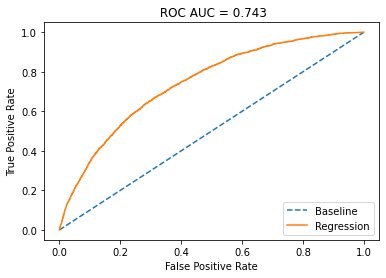

In [31]:
X, y = prepros(train).drop(columns= ['default']), train.default #num_cols +
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=seed )


m = CatBoostClassifier(
eval_metric='AUC',random_seed=seed,#early_stopping_rounds=50,
#                        ignored_features=['client_id'],
                       auto_class_weights= 'Balanced',
#                        iterations= 3000
                       
#                        eval_metric='AUC',random_seed=seed,
#                            metric_period=100,
                           depth=6,
                           l2_leaf_reg=8,
                           custom_loss=['AUC', 'Accuracy'],
#                            use_best_model=True,
#                            boosting_type='Ordered',
                           leaf_estimation_method='Newton',
#                        ignored_features=['client_id'],
#                        scale_pos_weight= (y_train == 0).sum()/(y_train == 1).sum(),
#                        auto_class_weights= 'Balanced',
#                        iterations= 5000
                      )
m.fit(X_train, y_train,cat_features=cat, eval_set=(X_test, y_test),plot=True)
probs = m.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title(' ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

После многочисленных эскперементов с предобработкой и созданинем дополнительных колонок, это наилучший результат к которому удалось прийти.

Изначально в предобработке были логарифмированы такие параметры как income и decline_app_cnt, были обработаны выбросы. Также были добавленны новые признаки на основе  наиболее влияющих на таргет-переменную признаков и добавленны полиномы всех числовых переменных и маштабированны все численные переменные.

OneHot кодированние не производилось так как CatBoost умеет это делать сам.

Однако оказалось что положительный эффект дают только приведение к численному виду колонки образования. 
Также при исследовании данных было выявленно наличие долгосрочного тренда дефолта от даты, а также связь дефолта с 
днем недели. Поэтому были введены доп. колонки с днем и номером недели в году.

Удаления наименее значимых для модели признаков также не привели к улучшению результата.

## Оптимизация гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'metric_period': [50,100,200],
    'depth':[6,10],
    'l2_leaf_reg':[5,8],
    'learning_rate':[0.005, 0.05,0.5, None],
    'leaf_estimation_method':['Newton', 'Gradient'],
     'auto_class_weights': ['Balanced','SqrtBalanced'],
}

grid_search = GridSearchCV(CatBoostClassifier(eval_metric='AUC',
                                              random_seed=seed,early_stopping_rounds=10),
                                               param_grid=params, n_jobs=-1,verbose=2)
grid_search.fit(X_train, y_train,cat_features=cat)
score = np.round(grid_search.score(X_test, y_test), 3)
print(f"Best random forest classifier score: {score}")
grid_search.best_params_ 

Тренировка на полных данных и инференс.

In [44]:
X, y = prepros(train).drop(columns= ['default']), train.default
m = CatBoostClassifier(
eval_metric='AUC',random_seed=seed,#early_stopping_rounds=50,
#                        ignored_features=['client_id'],
#                        auto_class_weights= 'Balanced',
#                        iterations= 3000
                       
#                        eval_metric='AUC',random_seed=seed,
#                            metric_period=100,
                           depth=6,
                           l2_leaf_reg=8,
                           custom_loss=['AUC', 'Accuracy'],
#                            use_best_model=True,
#                            boosting_type='Ordered',
                           leaf_estimation_method='Newton',
#                        ignored_features=['client_id'],
#                        scale_pos_weight= (y_train == 0).sum()/(y_train == 1).sum(),
                       auto_class_weights= 'Balanced'
#                        iterations= 5000
                      )
# print(X, y,cat)
m.fit(X, y,cat_features=cat)
probs = m.predict_proba(prepros(test))
test['default'] = probs[:,1]
test[['client_id', 'default']]

0:	total: 207ms	remaining: 3m 26s
1:	total: 361ms	remaining: 3m
2:	total: 499ms	remaining: 2m 45s
3:	total: 639ms	remaining: 2m 39s
4:	total: 779ms	remaining: 2m 35s
5:	total: 918ms	remaining: 2m 32s
6:	total: 1.07s	remaining: 2m 32s
7:	total: 1.2s	remaining: 2m 29s
8:	total: 1.36s	remaining: 2m 29s
9:	total: 1.53s	remaining: 2m 31s
10:	total: 1.67s	remaining: 2m 29s
11:	total: 1.79s	remaining: 2m 27s
12:	total: 1.94s	remaining: 2m 27s
13:	total: 2.07s	remaining: 2m 25s
14:	total: 2.27s	remaining: 2m 29s
15:	total: 2.58s	remaining: 2m 38s
16:	total: 2.73s	remaining: 2m 38s
17:	total: 2.88s	remaining: 2m 37s
18:	total: 3.03s	remaining: 2m 36s
19:	total: 3.19s	remaining: 2m 36s
20:	total: 3.32s	remaining: 2m 34s
21:	total: 3.52s	remaining: 2m 36s
22:	total: 3.71s	remaining: 2m 37s
23:	total: 3.89s	remaining: 2m 38s
24:	total: 4.06s	remaining: 2m 38s
25:	total: 4.22s	remaining: 2m 38s
26:	total: 4.42s	remaining: 2m 39s
27:	total: 4.56s	remaining: 2m 38s
28:	total: 4.71s	remaining: 2m 37s


235:	total: 34.9s	remaining: 1m 52s
236:	total: 35s	remaining: 1m 52s
237:	total: 35.1s	remaining: 1m 52s
238:	total: 35.3s	remaining: 1m 52s
239:	total: 35.4s	remaining: 1m 52s
240:	total: 35.6s	remaining: 1m 52s
241:	total: 35.7s	remaining: 1m 51s
242:	total: 36s	remaining: 1m 52s
243:	total: 36.2s	remaining: 1m 52s
244:	total: 36.3s	remaining: 1m 51s
245:	total: 36.5s	remaining: 1m 51s
246:	total: 36.7s	remaining: 1m 51s
247:	total: 36.9s	remaining: 1m 51s
248:	total: 37s	remaining: 1m 51s
249:	total: 37.3s	remaining: 1m 51s
250:	total: 37.5s	remaining: 1m 51s
251:	total: 37.6s	remaining: 1m 51s
252:	total: 37.8s	remaining: 1m 51s
253:	total: 38s	remaining: 1m 51s
254:	total: 38.2s	remaining: 1m 51s
255:	total: 38.3s	remaining: 1m 51s
256:	total: 38.5s	remaining: 1m 51s
257:	total: 38.7s	remaining: 1m 51s
258:	total: 38.8s	remaining: 1m 51s
259:	total: 39s	remaining: 1m 51s
260:	total: 39.2s	remaining: 1m 51s
261:	total: 39.4s	remaining: 1m 51s
262:	total: 39.6s	remaining: 1m 50s
26

465:	total: 1m 7s	remaining: 1m 17s
466:	total: 1m 8s	remaining: 1m 17s
467:	total: 1m 8s	remaining: 1m 17s
468:	total: 1m 8s	remaining: 1m 17s
469:	total: 1m 8s	remaining: 1m 17s
470:	total: 1m 8s	remaining: 1m 17s
471:	total: 1m 8s	remaining: 1m 16s
472:	total: 1m 8s	remaining: 1m 16s
473:	total: 1m 9s	remaining: 1m 16s
474:	total: 1m 9s	remaining: 1m 16s
475:	total: 1m 9s	remaining: 1m 16s
476:	total: 1m 9s	remaining: 1m 16s
477:	total: 1m 9s	remaining: 1m 16s
478:	total: 1m 9s	remaining: 1m 15s
479:	total: 1m 9s	remaining: 1m 15s
480:	total: 1m 10s	remaining: 1m 15s
481:	total: 1m 10s	remaining: 1m 15s
482:	total: 1m 10s	remaining: 1m 15s
483:	total: 1m 10s	remaining: 1m 15s
484:	total: 1m 10s	remaining: 1m 14s
485:	total: 1m 10s	remaining: 1m 14s
486:	total: 1m 10s	remaining: 1m 14s
487:	total: 1m 11s	remaining: 1m 14s
488:	total: 1m 11s	remaining: 1m 14s
489:	total: 1m 11s	remaining: 1m 14s
490:	total: 1m 11s	remaining: 1m 14s
491:	total: 1m 11s	remaining: 1m 13s
492:	total: 1m 1

693:	total: 1m 39s	remaining: 43.7s
694:	total: 1m 39s	remaining: 43.5s
695:	total: 1m 39s	remaining: 43.4s
696:	total: 1m 39s	remaining: 43.2s
697:	total: 1m 39s	remaining: 43.1s
698:	total: 1m 39s	remaining: 43s
699:	total: 1m 39s	remaining: 42.8s
700:	total: 1m 40s	remaining: 42.7s
701:	total: 1m 40s	remaining: 42.5s
702:	total: 1m 40s	remaining: 42.4s
703:	total: 1m 40s	remaining: 42.2s
704:	total: 1m 40s	remaining: 42.1s
705:	total: 1m 40s	remaining: 41.9s
706:	total: 1m 40s	remaining: 41.8s
707:	total: 1m 40s	remaining: 41.6s
708:	total: 1m 41s	remaining: 41.5s
709:	total: 1m 41s	remaining: 41.3s
710:	total: 1m 41s	remaining: 41.2s
711:	total: 1m 41s	remaining: 41s
712:	total: 1m 41s	remaining: 40.9s
713:	total: 1m 41s	remaining: 40.8s
714:	total: 1m 41s	remaining: 40.6s
715:	total: 1m 42s	remaining: 40.5s
716:	total: 1m 42s	remaining: 40.3s
717:	total: 1m 42s	remaining: 40.2s
718:	total: 1m 42s	remaining: 40s
719:	total: 1m 42s	remaining: 39.9s
720:	total: 1m 42s	remaining: 39.8

925:	total: 2m 11s	remaining: 10.5s
926:	total: 2m 11s	remaining: 10.4s
927:	total: 2m 11s	remaining: 10.2s
928:	total: 2m 11s	remaining: 10.1s
929:	total: 2m 11s	remaining: 9.93s
930:	total: 2m 12s	remaining: 9.78s
931:	total: 2m 12s	remaining: 9.64s
932:	total: 2m 12s	remaining: 9.5s
933:	total: 2m 12s	remaining: 9.36s
934:	total: 2m 12s	remaining: 9.22s
935:	total: 2m 12s	remaining: 9.07s
936:	total: 2m 12s	remaining: 8.93s
937:	total: 2m 13s	remaining: 8.79s
938:	total: 2m 13s	remaining: 8.65s
939:	total: 2m 13s	remaining: 8.51s
940:	total: 2m 13s	remaining: 8.37s
941:	total: 2m 13s	remaining: 8.22s
942:	total: 2m 13s	remaining: 8.08s
943:	total: 2m 13s	remaining: 7.94s
944:	total: 2m 13s	remaining: 7.8s
945:	total: 2m 14s	remaining: 7.66s
946:	total: 2m 14s	remaining: 7.51s
947:	total: 2m 14s	remaining: 7.37s
948:	total: 2m 14s	remaining: 7.23s
949:	total: 2m 14s	remaining: 7.09s
950:	total: 2m 14s	remaining: 6.95s
951:	total: 2m 14s	remaining: 6.8s
952:	total: 2m 15s	remaining: 6

,client_id,default
0,74835,0.190653
1,17527,0.668973
2,75683,0.372324
3,26883,0.365202
4,28862,0.070457
...,...,...
36344,83775,0.794850
36345,106254,0.048454
36346,81852,0.718721
36347,1971,0.754890


In [45]:
test[['client_id', 'default']].to_csv('subm_14.csv', index=False)

## Выводы

1. Созданна модель прогноза дефолта на основе CatBoost.
2. Получен результат ROC AUC 0.74358 что соответствует 3-му месту из 433 в соревновании Kaggle.
3. Данный проект показал что CatBoost с настройками по умолчанию довольно хорошо справляется с задачей и большинство преобразований данных не дают улучшения результата. В итоговой модели, по сравнению с BaseLine улучшение только c 0.74103 до 0.74358.

